<a href="https://colab.research.google.com/github/mmsamiei/MS-Thesis-Phase3/blob/master/Models/Boroujerdi/Boroujerdi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#In the name of God

In [1]:
import IPython
from google.colab import output

display(IPython.display.Javascript('''
  function ClickConnect(){
    console.log("Working"); 
    document.querySelector("colab-connect-button").click() 
  }
  var connect_timer = setInterval(ClickConnect,60000)
'''))

print("Done.")

<IPython.core.display.Javascript object>

Done.


In [2]:
!nvidia-smi

Mon Jun 15 17:46:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!pip -q install transformers

     |████████████████████████████████| 675kB 2.9MB/s 
     |████████████████████████████████| 890kB 8.5MB/s 
     |████████████████████████████████| 1.1MB 16.3MB/s 
     |████████████████████████████████| 3.8MB 25.6MB/s 


In [0]:
from torch.utils.data import Dataset, DataLoader
import os
import torch
import json
from torch.utils.data.sampler import SubsetRandomSampler
from transformers import AutoTokenizer
import random
import pandas as pd
import logging
import os

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from transformers import AutoModel

# Dataset

In [0]:
train_file = '/content/drive/My Drive/Thesis/phase-3/hkr_train.csv'
valid_file =  '/content/drive/My Drive/Thesis/phase-3/hkr_valid.csv'

In [7]:
tokenizer = AutoTokenizer.from_pretrained('google/bert_uncased_L-2_H-128_A-2')

In [0]:
df = pd.read_csv(train_file)

In [9]:
df

,Unnamed: 0,history,knowledge,response
0,0,Science fiction,Science fiction (often shortened to SF or sci-...,I think science fiction is an amazing genre fo...
1,1,Science fiction [SEP] I think science fiction ...,Science fiction films have often been used to ...,Awesome! I really love how sci-fi storytellers...
2,2,Science fiction [SEP] I think science fiction ...,The central premise for these stories oftentim...,"It's not quite sci-fi, but my favorite version..."
3,3,Science fiction [SEP] I think science fiction ...,Science fiction often explores the potential c...,If you really want a look at the potential neg...
4,4,Science fiction [SEP] I think science fiction ...,no_passages_used,It blends science fiction and paranormal/psych...
...,...,...,...,...
41484,41484,Beard [SEP] These days I am trying to grow a b...,The Egyptian priest class ritualistically remo...,Have you considered head shaving as well? Just...
41485,41485,Collie,The collie is a distinctive type of herding do...,Have you ever heard of the Collie dog? Its a h...
41486,41486,Collie [SEP] Have you ever heard of the Collie...,The Border Collie is a working and herding dog...,"One of my favorites is the Border Collie, whic..."
41487,41487,Collie [SEP] Have you ever heard of the Collie...,Their ability to be trained to act on the soun...,I prefer collies cause they can be trained and...


In [0]:
class MyDataset(Dataset):
    """My dataset."""

    def __init__(self, csv_file, frac=1, split_rate=1, bound=False, max_len=512, sort=True):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
        """
        self.dialogues = pd.read_csv(csv_file)
        self.dialogues.dropna(inplace=True)
        if bound:
          self.dialogues = self.dialogues[(self.dialogues['history'].apply(len)<280) 
          & (self.dialogues['history'].apply(len)<280) 
          & (self.dialogues['knowledge'].apply(len)<280)]
        
        self.dialogues = self.dialogues[self.dialogues.index % split_rate == 0]

        self.dialogues = self.dialogues.sample(frac=frac)
        
        s = self.dialogues['response'].apply(tokenizer.encode).apply(len).sort_values().index
        self.dialogues = self.dialogues.reindex(s)
        # s = (self.dialogues.false_sentence.str.len() + self.dialogues.history.str.len()).sort_values().index
        # self.dialogues = self.dialogues.reindex(s)


        self.dialogues.dropna(inplace=True)

        self.max_len = max_len


    def __len__(self):
        return len(self.dialogues)

    @staticmethod
    def truncuate_join_pair_sentence(sentence1, sentence2, max_len=510):

        """
        truncuate sentence one from head and sentence two from tail
        Args:
            sentence1 (string): first sentence
            sentence2 (string): seconde sentence
        """
        temp1 = tokenizer.encode(sentence1,add_special_tokens=False)
        temp2 = tokenizer.encode(sentence2,add_special_tokens=False)
        ### two above line may cause warning but no problem because we've handle them below
        logging.getLogger("transformers.tokenization_utils").setLevel(logging.ERROR)
        seq_1 = temp1
        seq_2 = temp2
        num_tokens_to_remove = len(temp1) + len(temp2) + 3 - max_len
        if num_tokens_to_remove > 0 :
            seq_1, seq_2, _ = tokenizer.truncate_sequences(temp1[::-1],temp2, num_tokens_to_remove=num_tokens_to_remove)
            seq_1.reverse()
        result_list = [tokenizer.cls_token_id]+seq_1+[tokenizer.sep_token_id]+seq_2+[tokenizer.sep_token_id]
        token_type_ids = [0] * (len(seq_1) + 2) + [1] * (len(seq_2) + 1)
        return result_list, token_type_ids


    def __getitem__(self, idx):
      
        
        history = self.dialogues.iloc[idx].history
        knowledge = self.dialogues.iloc[idx].knowledge
        response = self.dialogues.iloc[idx].response


        input_pair, input_pair_segments = MyDataset.truncuate_join_pair_sentence(history, knowledge, self.max_len)
                

        input_pair = torch.LongTensor(input_pair)

        input_pair_segments = torch.LongTensor(input_pair_segments)

        response_tensor = torch.LongTensor(tokenizer.encode(response))

        sample = {'input_pair': input_pair,
                  'input_pair_segments': input_pair_segments,
                  'response': response_tensor}

        return sample


In [106]:
train_dataset = MyDataset(train_file, max_len=128)
valid_dataset = MyDataset(valid_file, max_len=510)
print(len(train_dataset))
print(len(valid_dataset))

41489
4458


In [107]:
tokenizer.decode(train_dataset[5]['input_pair'])
tokenizer.decode(train_dataset[5]['response'])

'[CLS] bill finger [SEP]'

In [108]:
from tqdm.auto import tqdm

def my_collate_fn(batch):

  len_batch = len(batch)

  
  max_len_input_pair = max([len(data['input_pair']) for data in batch])

  max_len_response = max([len(data['response']) for data in batch])
  
  padding_ind = 0 ## for bert is 0 DON'T THINK BAD IT IS NOT REFACTORING !!!!!!
  result_input_pair = torch.zeros(len_batch, max_len_input_pair)
  result_input_pair_segments = torch.zeros(len_batch, max_len_input_pair)
  result_response = torch.zeros(len_batch, max_len_response)

  for i, data in enumerate(batch):
    p1 = len(data['input_pair'])
    result_input_pair[i, :p1] = data['input_pair']

    p3 = len(data['input_pair_segments'])
    result_input_pair_segments[i, :p3] = data['input_pair_segments']

    p4 = len(data['response'])
    result_response[i, :p4] = data['response']

  return result_input_pair.long(), result_input_pair_segments.long(), result_response.long()

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64,
                                             shuffle=False, collate_fn=my_collate_fn,
                                           num_workers=1)

valid_sampler = torch.utils.data.SequentialSampler(valid_dataset)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, sampler=valid_sampler,
                                             shuffle=False, collate_fn=my_collate_fn, num_workers=1)

i = 0 
for batch_idx, batch  in tqdm(enumerate(train_loader)):
  pair_batch, segment_batch, response_batch = batch
  print(pair_batch.shape)
  print(segment_batch.shape)
  print(response_batch.shape)
  print("****")
  i += 1 
  if(i==2):
    break

print(len(train_loader))
print(len(valid_loader))

torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 6])
****
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 7])
****
649
70


# Model

In [0]:
from transformers import EncoderDecoderModel, BertTokenizer

class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()

    self.seq2seq = EncoderDecoderModel.from_encoder_decoder_pretrained(
        'google/bert_uncased_L-2_H-128_A-2', 'google/bert_uncased_L-2_H-128_A-2')
    
    for p in self.seq2seq.encoder.embeddings.parameters():
      p.requires_grad = False
    
    for p in self.seq2seq.decoder.bert.embeddings.parameters():
      p.requires_grad = False

  def forward(self, encoder_input, segments_tensors, decoder_input):
    '''
    encoder_input = [batch_size, enc_len]
    segments_tensors = [batch_size, enc_len]
    decoder_input = [batch_size, dec_len]
    '''
    kwargs = {'token_type_ids':segments_tensors}
    outputs = self.seq2seq(input_ids=encoder_input, decoder_input_ids=decoder_input, **kwargs)[0]
    return outputs
  
  def generate(self, encoder_input, segments_tensors):
    kwargs = {'token_type_ids':segments_tensors}
    generated = model.seq2seq.generate(encoder_input, decoder_start_token_id=101,
                                       num_beams=5,no_repeat_ngram_size=3,**kwargs) ## [CLS] = 101
    return generated

In [110]:
dev = torch.device('cuda')
model = Model().to(dev)

# x = torch.LongTensor(200, 40).random_(1,1000).to(dev)
# print(model(x).shape)


def count_parameters(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

1006010


#Optimizer



In [0]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
    
    def zero_grad(self):
        self.optimizer.zero_grad()

In [0]:
optimizer2 = NoamOpt(128, 1, 2000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
optimizer = NoamOpt(128, 0.5, 700,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
#optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

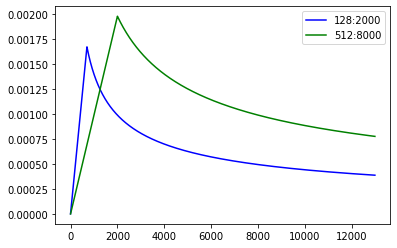

In [138]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.arange(1, 20*649), [optimizer.rate(i) for i in range(1, 20*649)], color='blue')
plt.plot(np.arange(1, 20*649), [optimizer2.rate(i) for i in range(1, 20*649)], color='green')
plt.legend(["128:2000", "512:8000", "256:4000"])

In [139]:
print("Maximum learning rate is:",max([optimizer.rate(i) for i in range(1, 20*649)]))

Maximum learning rate is: 0.0016703827619526524


In [140]:
print("Minimum learning rate is:",min([optimizer.rate(i) for i in range(1, 20*649)]))

Minimum learning rate is: 2.3862610885037896e-06


In [141]:
print("Peak step is:",max(enumerate([optimizer.rate(i) for i in range(1, 20*649)]), key=lambda x: x[1])[0])

Peak step is: 699


# Training

In [0]:
import torch.nn

def mahdi_loss(model_output, true_trg, **kwargs):
  '''
  model_output: [batch, len, hidden]
  true_trg: [batch, len]
  '''
  model_output = model_output[:,:-1,:]
  true_trg = true_trg[:,1:]

  if 'easy_training' in kwargs:
    limit_last_tokens = kwargs['easy_training']
    model_output = model_output[:,-limit_last_tokens:,:]
    true_trg = true_trg[:,-limit_last_tokens:]

  batch_len = model_output.shape[0]
  snt_len = model_output.shape[1]
  hidden_size = model_output.shape[2]

  model_output = model_output.reshape(-1, hidden_size)
  true_trg = true_trg.reshape(-1)

  loss_mod = nn.CrossEntropyLoss(ignore_index=0)## PAD = 0
  loss = loss_mod(model_output, true_trg)
  return loss

In [0]:
from tqdm.auto import tqdm

def train_step(batch_idx, batch):
  pair_batch, segment_batch, response_batch = batch
  pair_batch = pair_batch.to(dev)
  segment_batch = segment_batch.to(dev)
  response_batch = response_batch.to(dev)
  model_output = model(pair_batch, segment_batch, response_batch)
  kwargs = {'easy_training':4}
  loss = mahdi_loss(model_output, response_batch, **kwargs)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  del pair_batch
  del segment_batch
  del response_batch
  return loss.item()

def valid_step(batch_idx, batch):
  with torch.no_grad():
    pair_batch, segment_batch, response_batch = batch
    pair_batch = pair_batch.to(dev)
    segment_batch = segment_batch.to(dev)
    response_batch = response_batch.to(dev)
    model_output = model(pair_batch, segment_batch, response_batch)
    loss = mahdi_loss(model_output, response_batch)
    del pair_batch
    del segment_batch
    del response_batch
    return loss.item()

def valid_loop(valid_loader):
  total_loss = 0
  model.eval()
  for batch_idx, batch in tqdm(enumerate(valid_loader),  total=len(valid_loader)):
    total_loss += valid_step(batch_idx, batch)
  valid_inference(valid_loader)
  return total_loss / len(valid_loader)

def valid_inference(valid_loader):
  idx, batch = next(enumerate(valid_loader))
  pair_batch, segment_batch, response_batch = batch
  pair_batch = pair_batch.to(dev)[0:2] ## Size batch is 2
  segment_batch = segment_batch.to(dev)[0:2] ## Size batch is 2
  response_batch = response_batch.to(dev)[0:2] ## Size batch is 2
  model_output = model.generate(pair_batch, segment_batch)
  print("response is: ",tokenizer.decode(response_batch[0]))
  print("model says: ",tokenizer.decode(model_output[0]))
  print("---"*3)
  print("response is: ",tokenizer.decode(response_batch[1]))
  print("model says: ",tokenizer.decode(model_output[1]))
  print("**** ****"*5)

In [0]:
new_learning = True
if new_learning:
  # optimizer = NoamOpt(128, 1, 2000,
  #           torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
  model_dir = "/content/drive/My Drive/Thesis/phase-3/Models/Boroujerdi/"
  step = 0
  log_list = []

In [0]:
## if continue learning:
#!wget -q https://github.com/mmsamiei/MS-Thesis-Phase2/raw/master/Models/hashemi_16000steps.model
model_dir = "/content/drive/My Drive/Thesis/phase-3/Models/Boroujerdi"
checkpoint = torch.load(model_dir+'boroujerdi_25000steps.model')
step = checkpoint['log_list'][-1]['step']
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
optimizer._step = step
log_list = checkpoint['log_list']
new_learning = False
print(step)

In [0]:
from tqdm.auto import tqdm

MAX_STEP = 20000
STEP_SAVE = 500
STEP_CHECK = 100
step_num = step + 1
log_list = log_list ### Check if new learning or not
print(step_num)
while step_num <= MAX_STEP:
  model.train()
  for batch_idx, batch in tqdm(enumerate(iter(train_loader)), total=len(train_loader)):
    step_loss = train_step(batch_idx, batch)
    log = {'step':step_num, 'train_loss':step_loss}
    if(step_num % STEP_CHECK == 0):
      valid_error = valid_loop(valid_loader)
      print("valid Loss rate: {} at step {}".format(valid_error, step_num))  
      log['valid_loss'] = valid_error
      log_list.append(log)
      model.train()
      torch.save({
            'model_state_dict': model.state_dict(),
            'log_list': log_list,
            'optimizer_state_dict': optimizer.optimizer.state_dict() 
            }, model_dir+'boroujerdi_{}steps.model'.format(step_num))
      step_num += 1
      continue
    
    log_list.append(log)
    if(step_num % STEP_SAVE == 0):
      torch.save({
            'model_state_dict': model.state_dict(),
            'log_list': log_list,
            'optimizer_state_dict': optimizer.optimizer.state_dict()
            }, model_dir+'boroujerdi_{}steps.model'.format(step_num))
    step_num += 1

1



response is:  [CLS] hello [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS]. [SEP] [SEP] ” ” [SEP]. [SEP] “ ” [SEP] ” [SEP] [SEP] [SEP] “ [SEP] ”.
---------
response is:  [CLS] topic map [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS]. [SEP] [SEP] ” ” [SEP]. [SEP] “ ” [SEP] ” [SEP] [SEP] [SEP] “ [SEP]? [SEP]
**** ******** ******** ******** ******** ****
valid Loss rate: 0.11063907840638056 at step 100



response is:  [CLS] hello [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS]. [SEP] [SEP] [SEP] " " s s s a a good good good fun " [SEP] [SEP].
---------
response is:  [CLS] topic map [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS]. [SEP] [SEP] [SEP] " " " s s s " not not not like you? [SEP] [SEP]
**** ******** ******** ******** ******** ****
valid Loss rate: 0.12091592386090846 at step 200



response is:  [CLS] hello [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] [SEP] [SEP] [SEP].. [SEP] [SEP]? [SEP] you you? [SEP]. [SEP]??? [SEP]
---------
response is:  [CLS] topic map [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] [SEP] [SEP] [SEP].. [SEP] [SEP]? [SEP] s s. [SEP]. [SEP] i think about you
**** ******** ******** ******** ******** ****
valid Loss rate: 0.12385095668619873 at step 300



response is:  [CLS] hello [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] [SEP] [SEP] [SEP]. [SEP] [SEP]! [SEP] [SEP]? [SEP] [SEP] i like like like the the the
---------
response is:  [CLS] topic map [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS]. [SEP] [SEP] [SEP]. [SEP] html html. [SEP]. html. html / html html html and
**** ******** ******** ******** ******** ****
valid Loss rate: 0.11463552978125427 at step 400



response is:  [CLS] hello [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS]. [SEP]... [SEP] you you you like it? [SEP] you??? you?
---------
response is:  [CLS] topic map [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS]... you you you? you you like it?? do you you it it?
**** ******** ******** ******** ******** ****
valid Loss rate: 0.10809419913482324 at step 500



response is:  [CLS] hello [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS]? [SEP] [SEP] [SEP]?? [SEP]? [SEP] the the. [SEP] [SEP] the world in the world
---------
response is:  [CLS] topic map [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS]? [SEP] [SEP] [SEP]. [SEP] [SEP]? [SEP] the the world [SEP] [SEP] the world of the world
**** ******** ******** ******** ******** ****
valid Loss rate: 0.11066420423765255 at step 600




response is:  [CLS] hello [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS]. is a very good to be a small instrument. [SEP] [SEP] [SEP] the air. [SEP] s
---------
response is:  [CLS] topic map [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS]. i love and is a a very very popular example. [SEP] [SEP] [SEP] i think. [SEP]
**** ******** ******** ******** ******** ****
valid Loss rate: 0.0937853575073694 at step 700



response is:  [CLS] hello [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS]. [SEP] [SEP] [SEP] in the united states in the new york in the world [SEP] [SEP]. [SEP]
---------
response is:  [CLS] topic map [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS]. [SEP] [SEP] [SEP] do you like in the world in the united states? [SEP] [SEP]. [SEP]
**** ******** ******** ******** ******** ****
valid Loss rate: 0.10698226440535794 at step 800



response is:  [CLS] hello [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] [SEP] [SEP]. [SEP] [SEP] [SEP]? [SEP] [SEP] do you like it. [SEP] you have it?
---------
response is:  [CLS] topic map [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] [SEP] [SEP]. [SEP] [SEP]? [SEP] [SEP] [SEP] do you? [SEP] this is the same time.
**** ******** ******** ******** ******** ****
valid Loss rate: 0.10610526439158464 at step 900



response is:  [CLS] hello [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS]. [SEP] [SEP] [SEP] i [SEP] [SEP]? [SEP] [SEP]. [SEP] i. [SEP] so much of the
---------
response is:  [CLS] topic map [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS]. [SEP] [SEP] [SEP] this [SEP] [SEP]? [SEP] [SEP] in the world. [SEP] i is so much
**** ******** ******** ******** ******** ****
valid Loss rate: 0.10677220202069905 at step 1000



response is:  [CLS] hello [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS]!...! you like you?? [SEP]? [SEP] you?. [SEP] [SEP] [SEP]
---------
response is:  [CLS] topic map [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS]. how about you want about you do you? [SEP] [SEP]? [SEP] you do it? [SEP]
**** ******** ******** ******** ******** ****
valid Loss rate: 0.09476240615023257 at step 1100



response is:  [CLS] hello [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS]. [SEP] [SEP] [SEP]. : ) ) ) [SEP] : ), and - - - ) [SEP]
---------
response is:  [CLS] topic map [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] it? [SEP] [SEP] [SEP]. : ) ) )... you? [SEP]. [SEP].
**** ******** ******** ******** ******** ****
valid Loss rate: 0.0909958170261443 at step 1200




response is:  [CLS] hello [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS]. [SEP]. [SEP]? [SEP] [SEP] : : : ). [SEP] [SEP] [SEP] following. [SEP] her
---------
response is:  [CLS] topic map [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS]. [SEP]. [SEP] [SEP] [SEP].. [SEP] this. [SEP]? [SEP] [SEP]! [SEP] [SEP]?
**** ******** ******** ******** ******** ****
valid Loss rate: 0.095879467253516 at step 1300



response is:  [CLS] hello [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS]. do you have a long time in the middle time to go [SEP] [SEP] [SEP]? do you
---------
response is:  [CLS] topic map [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS]. do you have a variety of the environment to the environment. [SEP] [SEP]? do you enjoy
**** ******** ******** ******** ******** ****
valid Loss rate: 0.0921565963313846 at step 1400



response is:  [CLS] hello [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] in the year. [SEP] [SEP] i am a year. do you like them? [SEP] [SEP] [SEP]
---------
response is:  [CLS] topic map [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] do you do? [SEP] d do you enjoy it. do you like to work? [SEP] [SEP]
**** ******** ******** ******** ******** ****
valid Loss rate: 0.09273119665892897 at step 1500



response is:  [CLS] hello [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] do you do you like? [SEP] [SEP] d's. [SEP] [SEP] an extra of the best
---------
response is:  [CLS] topic map [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] do do you like it? [SEP] do you have a lot [SEP] [SEP] you like a good job
**** ******** ******** ******** ******** ****
valid Loss rate: 0.09524361592015113 at step 1600



response is:  [CLS] hello [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] do do you do you like football? [SEP] [SEP] in the field in the majors. [SEP] i
---------
response is:  [CLS] topic map [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] do you do you have a lot. [SEP] [SEP] [SEP] a lot of information [SEP] [SEP] in the
**** ******** ******** ******** ******** ****
valid Loss rate: 0.09433060475345575 at step 1700



response is:  [CLS] hello [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS]. [SEP] [SEP] i do you like you like it? [SEP]? [SEP] [SEP] a long time ago
---------
response is:  [CLS] topic map [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS]. [SEP] [SEP] the team. [SEP]. [SEP] a long time! [SEP] [SEP] a few years of
**** ******** ******** ******** ******** ****
valid Loss rate: 0.09001723657867308 at step 1800



response is:  [CLS] hello [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] do you like to do. [SEP] [SEP] [SEP] the same? [SEP] [SEP]. [SEP] the first of
---------
response is:  [CLS] topic map [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS]'s. [SEP] i think. [SEP]. [SEP] the world. [SEP] do you like it?
**** ******** ******** ******** ******** ****
valid Loss rate: 0.08919465835985446 at step 1900




response is:  [CLS] hello [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] do you like to do you play to do it? [SEP] [SEP] [SEP] california? [SEP]? [SEP]
---------
response is:  [CLS] topic map [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] do you do you want to do you play? [SEP] [SEP]? [SEP] you like it? [SEP]
**** ******** ******** ******** ******** ****
valid Loss rate: 0.0885365868213734 at step 2000



response is:  [CLS] hello [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] in the united states in the summer in the world in the middle time. [SEP] [SEP] [SEP] i
---------
response is:  [CLS] topic map [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] are very useful. do not do not have to be used to do. [SEP] [SEP] [SEP].
**** ******** ******** ******** ******** ****
valid Loss rate: 0.09294426553502859 at step 2100



response is:  [CLS] hello [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] is a lot of more than one in a few years [SEP] in the united states in the world
---------
response is:  [CLS] topic map [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] the other uses of the other is a new with a lot of more than one day. [SEP]
**** ******** ******** ******** ******** ****
valid Loss rate: 0.09007523925168572 at step 2200



response is:  [CLS] hello [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] a high level of the high level [SEP] in the upper the middle of the upper of the middle
---------
response is:  [CLS] topic map [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] the same is so much more more more in the same time in the middle of the whole of
**** ******** ******** ******** ******** ****
valid Loss rate: 0.09002838759424442 at step 2300



response is:  [CLS] hello [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] of the other. [SEP] [SEP]. [SEP] is you? [SEP]? [SEP] you played? [SEP] [SEP]
---------
response is:  [CLS] topic map [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] of the same is a of the of the other. [SEP] [SEP] [SEP] in the other [SEP] [SEP]
**** ******** ******** ******** ******** ****
valid Loss rate: 0.08947133226424603 at step 2400



response is:  [CLS] hello [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] hot. [SEP] [SEP] [SEP] i like the most. [SEP] the field in the world. [SEP] i
---------
response is:  [CLS] topic map [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] air. [SEP] [SEP]. [SEP] the same time. [SEP] other information is your favorite? [SEP] a
**** ******** ******** ******** ******** ****
valid Loss rate: 0.08873123660543245 at step 2500




response is:  [CLS] hello [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] athletics. [SEP] [SEP] [SEP] ) [SEP] hawaii. [SEP] the world [SEP] i love it. [SEP] i
---------
response is:  [CLS] topic map [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS]. [SEP] [SEP] [SEP] nascar [SEP] fastest. [SEP] team [SEP] fastest time [SEP] olympics [SEP] olympics. [SEP]
**** ******** ******** ******** ******** ****
valid Loss rate: 0.09342360443039933 at step 2600



response is:  [CLS] hello [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS]. [SEP] you are a long time in the middle ages? [SEP] [SEP] [SEP] you? [SEP] you
---------
response is:  [CLS] topic map [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS]. [SEP] do you have a long time in the field? [SEP] [SEP] [SEP]. [SEP] you are
**** ******** ******** ******** ******** ****
valid Loss rate: 0.09192134960717073 at step 2700



response is:  [CLS] hello [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] hot 100 years. [SEP] is my favorite in the high - level of all time. [SEP] [SEP]
---------
response is:  [CLS] topic map [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] do you have to do you do you like to choose to do the user. [SEP] [SEP] [SEP]
**** ******** ******** ******** ******** ****
valid Loss rate: 0.08950213457555073 at step 2800



response is:  [CLS] hello [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] it is the best of it. [SEP] in the new york. [SEP] you like a lot of
---------
response is:  [CLS] topic map [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] it is my favorite of it. [SEP] in the new york. [SEP]. do you have any
**** ******** ******** ******** ******** ****
valid Loss rate: 0.08803374513803228 at step 2900



response is:  [CLS] hello [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] do you like football? [SEP] football. [SEP] [SEP]? [SEP] you like it? [SEP] in the
---------
response is:  [CLS] topic map [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] do you think? [SEP]? [SEP]. [SEP] [SEP] [SEP] in the world [SEP] [SEP] a lot of
**** ******** ******** ******** ******** ****
valid Loss rate: 0.09227407304841663 at step 3000



response is:  [CLS] hello [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] water. [SEP] you you like hockey is your favorite sport? [SEP] [SEP]? [SEP] a long time
---------
response is:  [CLS] topic map [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] information. [SEP] i have you ever been on the field. [SEP] [SEP] [SEP] the field of the
**** ******** ******** ******** ******** ****
valid Loss rate: 0.08748064237948007 at step 3100



response is:  [CLS] hello [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] it. [SEP] [SEP] [SEP]. [SEP]? [SEP] [SEP] ) [SEP] [SEP] i think. [SEP] you?
---------
response is:  [CLS] topic map [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] information. [SEP] you are? [SEP]? [SEP]. [SEP] [SEP] [SEP] a lot. [SEP] i think
**** ******** ******** ******** ******** ****
valid Loss rate: 0.0877108552521149 at step 3200




response is:  [CLS] hello [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS]. [SEP] [SEP] [SEP] do you like to do you? [SEP] [SEP]? [SEP]. [SEP]! [SEP]
---------
response is:  [CLS] topic map [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] do you enjoy sports? [SEP] [SEP] [SEP] do you do you? [SEP] )? [SEP]? [SEP]
**** ******** ******** ******** ******** ****
valid Loss rate: 0.08564578497447257 at step 3300



response is:  [CLS] hello [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS]. [SEP] do you like the field of the first in the summer olympics? [SEP] [SEP] [SEP] you
---------
response is:  [CLS] topic map [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS]. [SEP] do you like the best in the field of the university of mathematics. [SEP] [SEP] [SEP]
**** ******** ******** ******** ******** ****
valid Loss rate: 0.09321279031591813 at step 3400



response is:  [CLS] hello [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] is the best of the most of the of the best to get to get a lot of you
---------
response is:  [CLS] topic map [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] do you enjoy the field of the other in the of the united states of the new york?
**** ******** ******** ******** ******** ****
valid Loss rate: 0.09011641956327635 at step 3500



response is:  [CLS] hello [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] do you like the field? [SEP] is? [SEP] in the united states in the new york,
---------
response is:  [CLS] topic map [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] do not do not have the the other in the of the most of the same of the other
**** ******** ******** ******** ******** ****
valid Loss rate: 0.09059078664510119 at step 3600



response is:  [CLS] hello [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] is my favorite of the best of my favorite instrument. [SEP] [SEP] [SEP]. [SEP]! [SEP] [SEP]
---------
response is:  [CLS] topic map [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] in the other other other information is the other information. [SEP]. [SEP] are your favorite in the
**** ******** ******** ******** ******** ****
valid Loss rate: 0.08682610144685768 at step 3700



response is:  [CLS] hello [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS]. [SEP] [SEP] do you like the other is your favorite in the other kinds of with the other
---------
response is:  [CLS] topic map [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS]. [SEP]. [SEP] do you have any other information on the other information and the same is the
**** ******** ******** ******** ******** ****
valid Loss rate: 0.08676882654415112 at step 3800




response is:  [CLS] hello [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS]. [SEP] [SEP] i love me [SEP] [SEP] you? [SEP] [SEP] [SEP]. [SEP] i was born [SEP]
---------
response is:  [CLS] topic map [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] [SEP] bmw [SEP] ferrari [SEP] ferrari. [SEP] [SEP] bmw. [SEP]. [SEP] honda [SEP] honda. [SEP]
**** ******** ******** ******** ******** ****
valid Loss rate: 0.09204064136452074 at step 3900



response is:  [CLS] hello [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS], etc. do you have you ever been to visit there? [SEP] [SEP] [SEP]. [SEP] california
---------
response is:  [CLS] topic map [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] is very interesting to communicate information information information and information information. [SEP]. [SEP] [SEP] [SEP] you?
**** ******** ******** ******** ******** ****
valid Loss rate: 0.0883234008217457 at step 4000



response is:  [CLS] hello [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] in the united states. do you enjoy my favorite united states in the us? [SEP] [SEP] [SEP]
---------
response is:  [CLS] topic map [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] are very interesting. [SEP] are not not not very interesting to provide any information. [SEP] [SEP] [SEP]
**** ******** ******** ******** ******** ****
valid Loss rate: 0.09069532811133622 at step 4100



response is:  [CLS] hello [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] do you like to do you have you like the best for my favorite in the united states and
---------
response is:  [CLS] topic map [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] do you have a new to do you like a new new to be a new position of the
**** ******** ******** ******** ******** ****
valid Loss rate: 0.0900792213446787 at step 4200



response is:  [CLS] hello [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] do you like the sancho, and other and other are too much of my life in the
---------
response is:  [CLS] topic map [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] do not do not have a lot of any other or not not not with the right to the
**** ******** ******** ******** ******** ****
valid Loss rate: 0.08970557001472429 at step 4300



response is:  [CLS] hello [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] do you like the other are a very very tacos, etc. do you have any other
---------
response is:  [CLS] topic map [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] do not have a not not not a very to a few or not not with any of the
**** ******** ******** ******** ******** ****
valid Loss rate: 0.0927046367864322 at step 4400



response is:  [CLS] hello [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] do you like to do with the are your own and are your favorite with your own with your
---------
response is:  [CLS] topic map [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] do not do not have the are not not not a and and the same of the other information
**** ******** ******** ******** ******** ****
valid Loss rate: 0.09063364412282925 at step 4500




response is:  [CLS] hello [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] in the united states of the united countries of the country. [SEP] you? [SEP]? [SEP] you
---------
response is:  [CLS] topic map [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] do you have any a free information information information? [SEP] [SEP]? [SEP] i think? [SEP] you
**** ******** ******** ******** ******** ****
valid Loss rate: 0.0844847816905402 at step 4600



response is:  [CLS] hello [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] do you like your own own own my own own country in the world? [SEP] [SEP] [SEP].
---------
response is:  [CLS] topic map [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] do not have not not not be not not very very interesting. [SEP] [SEP] [SEP]. [SEP].
**** ******** ******** ******** ******** ****
valid Loss rate: 0.08900379161227172 at step 4700



response is:  [CLS] hello [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] do you have a own a own own own my own name is my favorite in the world.
---------
response is:  [CLS] topic map [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] do not do not have not have any other information and other information to the other information. [SEP]
**** ******** ******** ******** ******** ****
valid Loss rate: 0.08780804146774791 at step 4800



response is:  [CLS] hello [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] do you have been to have been since been to do not have been in a good to be
---------
response is:  [CLS] topic map [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] do not do not have not have been to do not be a good to be a lot of
**** ******** ******** ******** ******** ****
valid Loss rate: 0.08993133101670825 at step 4900



response is:  [CLS] hello [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] do you like the other are are you like it? [SEP] [SEP] [SEP]? [SEP]. [SEP] [SEP]
---------
response is:  [CLS] topic map [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] are not not a lot of information in the same time. [SEP] [SEP] [SEP]? [SEP] [SEP].
**** ******** ******** ******** ******** ****
valid Loss rate: 0.09168299285217806 at step 5000



response is:  [CLS] hello [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] do you like your own your ownstastestestestastastastepings? [SEP]
---------
response is:  [CLS] topic map [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] do you have any other the other information on the other related information to the other relevant information.
**** ******** ******** ******** ******** ****
valid Loss rate: 0.09213145852035447 at step 5100




response is:  [CLS] hello [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] [SEP] do you like you like coffee? [SEP]? [SEP] [SEP] [SEP] you? [SEP] ) [SEP] [SEP]
---------
response is:  [CLS] topic map [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS]. [SEP] [SEP] [SEP] i guess [SEP] [SEP] though [SEP] [SEP] others [SEP] [SEP]. [SEP] i think.
**** ******** ******** ******** ******** ****
valid Loss rate: 0.09360425137468066 at step 5200



response is:  [CLS] hello [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] vitamins in a wide range of electronic fillings in the world. [SEP] [SEP] [SEP]. [SEP]
---------
response is:  [CLS] topic map [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] offer information based on the topic of the basis of the information. [SEP] [SEP] [SEP]. [SEP].
**** ******** ******** ******** ******** ****
valid Loss rate: 0.08710719245920913 at step 5300



response is:  [CLS] hello [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] am you like the best friendstastestastestestem in the world. [SEP] [SEP]
---------
response is:  [CLS] topic map [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
model says:  [CLS] is very good to be a good amount of the other information on the internet. [SEP] [SEP] [SEP]
**** ******** ******** ******** ******** ****
valid Loss rate: 0.09075154483772918 at step 5400


In [0]:
log_list

[{'step': 1, 'train_loss': 4.573500633239746},
 {'step': 2, 'train_loss': 4.6115217208862305},
 {'step': 3, 'train_loss': 4.456216335296631},
 {'step': 4, 'train_loss': 4.73253059387207},
 {'step': 5, 'train_loss': 4.493163585662842},
 {'step': 6, 'train_loss': 4.529580593109131},
 {'step': 7, 'train_loss': 4.4646735191345215},
 {'step': 8, 'train_loss': 4.375193119049072},
 {'step': 9, 'train_loss': 4.327970504760742},
 {'step': 10, 'train_loss': 4.130836486816406},
 {'step': 11, 'train_loss': 4.174636363983154},
 {'step': 12, 'train_loss': 4.1171674728393555},
 {'step': 13, 'train_loss': 4.341594219207764},
 {'step': 14, 'train_loss': 3.976616859436035},
 {'step': 15, 'train_loss': 4.0958733558654785},
 {'step': 16, 'train_loss': 4.037125110626221},
 {'step': 17, 'train_loss': 3.89686918258667},
 {'step': 18, 'train_loss': 3.7523674964904785},
 {'step': 19, 'train_loss': 3.707036256790161},
 {'step': 20, 'train_loss': 3.436854600906372},
 {'step': 21, 'train_loss': 3.627664089202881}

In [0]:
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
print(output)
output.backward()

tensor(1.5508, grad_fn=<NllLossBackward>)
